In [1]:
from torch import nn
import torch
from os.path import join
import pandas as pd
from matplotlib import pyplot as plt
import torch.nn.functional as F
import numpy as np
import random
import json
import yaml
import io

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 5.)
        m.bias.data.normal_(0.0, 5.)

class RND(nn.Module):
    def __init__(self, state_dim = 16, k = 16):
        super(RND, self).__init__()      
        self.first = True

        f1 = state_dim
        f2 = 32
        f3 = 16
        f4 = 16
        self.k = k
        
        # Experiment with 8 layers 16: No puede converger
        # Experiment p (16) t(2: Similar works, different does not converge
        # Experiment p (2) t(16): Similar partially works, different does not converge
        # Experiment 2 layers: Both does not work
        # Experiment two layers one activation: Terrible
        # Experiment one layer: Similar works well, different works some how well
            # Experiment with high k 256: Works pretty well both
            # Experiment with low k 8: Works better but maybe it is only for some cases
            # Experiment with low k without zero-one initialization: Works slightly better
            # Experiment with super high k 1028: Works no so well, but works


        self.target =  nn.Sequential(
                            nn.Linear(f1, k),                   #nn.Sigmoid(),
                            #nn.Linear(k, k),                    #nn.Sigmoid()
                            ) 

        
        self.predictor = nn.Sequential(
                            nn.Linear(f1, k),                   #nn.Sigmoid(),
                            #nn.Linear(k, k),                   # nn.Sigmoid()
                            )  
        self.predictor.apply(weights_init)
        self.target.apply(weights_init)
        
            
    def fix_target(self):
        for param in self.target.parameters():
            param.requires_grad = False

    def reset(self):
        self.predictor.apply(weights_init)
        self.target.apply(weights_init)

    def forward(self, x):
        to = self.target(x)
        po = self.predictor(x)

        mse = (to - po).pow(2).sum(0) / self.k * 2

        int_reward =  mse.detach().float().unsqueeze(0)

        return to, po, int_reward

def tl(x): return torch.from_numpy(x).float()

In [4]:
torch.set_printoptions(precision=3)

In [5]:
obs_n = 8
k = 16

SAMPLE_SIZE = 1_000
rnd = RND(state_dim = obs_n, k = k)
s = torch.rand(1, obs_n)

In [7]:
rnd(s)

(tensor([[  5.989,   3.837,  12.528,  -3.095,   2.396,   6.848, -10.121,  -2.893,
           -3.481,  -6.363,   6.615,   6.448,   1.989,   5.349,  -1.218, -14.138]],
        grad_fn=<AddmmBackward>),
 tensor([[ -4.149,  -0.585,   7.474,   8.203,  -6.495,  -1.791, -10.638,  -0.252,
           -1.784,  12.284,   3.278,  -4.085,   4.122,   5.700, -16.426,   5.026]],
        grad_fn=<AddmmBackward>),
 tensor([[1.285e+01, 2.444e+00, 3.193e+00, 1.596e+01, 9.882e+00, 9.329e+00,
          3.335e-02, 8.719e-01, 3.598e-01, 4.346e+01, 1.392e+00, 1.387e+01,
          5.685e-01, 1.544e-02, 2.891e+01, 4.591e+01]]))

In [6]:
predictor_opt = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-2)
target_opt = torch.optim.Adam(rnd.target.parameters(), lr = 1e-2)

pred_data_in = torch.rand((SAMPLE_SIZE, obs_n))
target_data_in = torch.rand((SAMPLE_SIZE, obs_n))

pred_data_out = torch.zeros((SAMPLE_SIZE, k), requires_grad=False)
target_data_out = torch.ones((SAMPLE_SIZE, k), requires_grad=False)

for i in range(SAMPLE_SIZE):
    pred_loss = F.binary_cross_entropy(rnd.predictor(pred_data_in[i]), pred_data_out[i])
    predictor_opt.zero_grad()
    pred_loss.backward()
    predictor_opt.step()

    target_loss = F.binary_cross_entropy(rnd.target(target_data_in[i]), target_data_out[i])
    target_opt.zero_grad()
    target_loss.backward()
    target_opt.step()


RuntimeError: all elements of input should be between 0 and 1

tensor([0.886, 0.367, 0.654, 0.050, 0.502, 0.836, 0.282, 0.284])

In [231]:
rnd(s)

(tensor([[0.999, 0.989, 1.000, 1.000, 0.980, 0.988, 1.000, 0.978, 0.999, 0.960,
          1.000, 1.000, 1.000, 1.000, 0.994, 1.000]], grad_fn=<SigmoidBackward>),
 tensor([[1.436e-08, 3.298e-05, 9.853e-04, 5.727e-07, 6.614e-07, 1.628e-03,
          1.466e-03, 5.039e-06, 5.065e-03, 1.142e-07, 9.962e-06, 3.715e-02,
          2.460e-08, 8.278e-06, 3.027e-07, 1.130e-02]],
        grad_fn=<SigmoidBackward>),
 tensor([[0.125, 0.122, 0.125, 0.125, 0.120, 0.122, 0.125, 0.120, 0.123, 0.115,
          0.125, 0.116, 0.125, 0.125, 0.123, 0.122]]))

In [14]:
#rnd = RND(state_dim = obs_n, k = k)
rnd.fix_target()
rnd_optimizer = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-1)


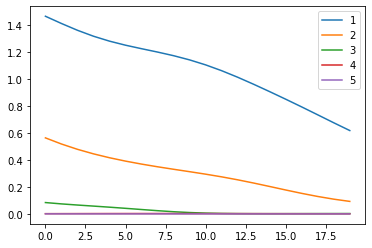

In [98]:


n_opt = 20

ep = 8
n = 401
path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
df = pd.read_csv(fn)


steps = [1,2,3,4,5]

for step in steps:
    
    features_ns = tl(df.iloc[step,1:].values)

    x = features_ns.unsqueeze(0)
    xs = torch.repeat_interleave(x, n_opt, dim=0)

    r = []

    for x_i in xs:
        t, p, ri = rnd(x_i)
        r.append(ri)
        int_loss = F.binary_cross_entropy(p, t.detach())
        rnd_optimizer.zero_grad()
        int_loss.backward()
        rnd_optimizer.step()

    plt.plot(r)
    
plt.legend(steps)

## Close samples. Should be close to zero

Text(0.5, 0, 'observaciones')

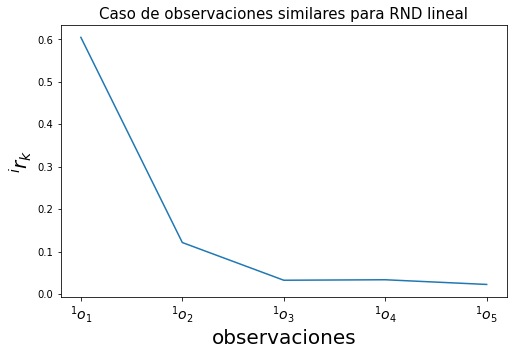

In [26]:
n_opt = 20

ep = 3
n = 401
path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
df = pd.read_csv(fn)


steps = [1,2,3,4,5]

f,ax = plt.subplots(1,1,figsize = (8,5))
r = []

for step in steps:
    features_ns = tl(df.iloc[step,1:].values)

    x = features_ns.unsqueeze(0)
    xs = torch.repeat_interleave(x, n_opt, dim=0)

    for i, x_i in enumerate(xs):
        t, p, ri = rnd(x_i)
        if i == 0:
            r.append(ri)
        
        int_loss = F.mse_loss(t.detach(),p)
        #int_loss = F.binary_cross_entropy(p, t.detach())
        rnd_optimizer.zero_grad()
        int_loss.backward()
        rnd_optimizer.step()

ax.plot(steps,r)

ax.set_title('Caso de observaciones similares para RND lineal', fontsize = 15)
leg = ['${}^1o_1$', '${}^1o_2$','${}^1o_3$', '${}^1o_4$', '${}^1o_5$']
plt.xticks(steps,leg, fontsize = 14)
ax.set_ylabel('${}^ir_k$', fontsize = 20)
ax.set_xlabel('observaciones', fontsize = 20)


## Close sample sample. See how is the distribution

RuntimeError: all elements of input should be between 0 and 1

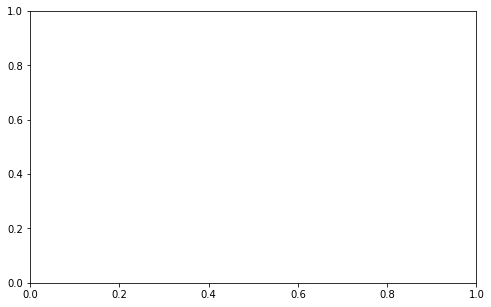

In [57]:

n_opt = 20

ep = 3
n = 110
path = '../specials/A2CiLSTMRNDPN/_0512_20-47-05/'
fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
df = pd.read_csv(fn)


steps = [1,1,1,1,1,1,1,1,1,1]

f,ax = plt.subplots(1,1,figsize = (8,5))

for step in steps:
    features_ns = tl(df.iloc[step,1:].values)

    x = features_ns.unsqueeze(0)
    xs = torch.repeat_interleave(x, n_opt, dim=0)
    rnd = RND(state_dim = 288)
    rnd_optimizer = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-1)

    r = []

    for x_i in xs:
        t, p, ri = rnd(x_i)
        r.append(ri)
        int_loss = F.binary_cross_entropy(p, t.detach())
        rnd_optimizer.zero_grad()
        int_loss.backward()
        rnd_optimizer.step()

    ax.plot(r)
    
plt.legend(steps)

## Samples from different episodes. Should be different.

Text(0.5, 0, 'epochs entrenamiento de RND')

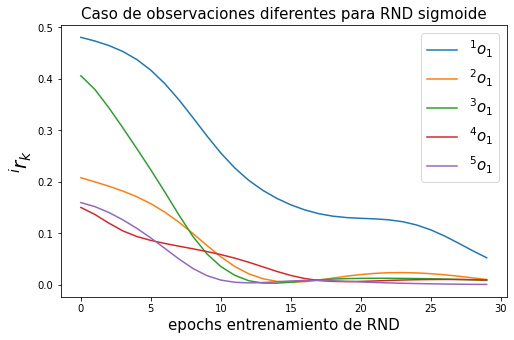

In [179]:
rnd = RND(state_dim = 8)

rnd_optimizer = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-1 )
n_opt = 30

ep = 3
path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
#path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'


ns = [401,401,401,401,401]#,401,401,401]# 67,8,89,110,30,116,201,194]
eps = [30,31,32,33,34,35]#,36,37]


f,ax = plt.subplots(1,1,figsize = (8,5))

for ep, n in zip(eps, ns):
    fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
    df = pd.read_csv(fn)
    features_ns = tl(df.iloc[-1,1:].values)

    x = features_ns.unsqueeze(0)
    xs = torch.repeat_interleave(x, n_opt, dim=0)

    r = []

    for x_i in xs:
        t, p, ri = rnd(x_i)
        r.append(ri)
        #int_loss = F.mse_loss(p, t.detach())
        int_loss = F.binary_cross_entropy(p, t.detach())
        
        rnd_optimizer.zero_grad()
        int_loss.backward()
        rnd_optimizer.step()

    ax.plot(r)
    
ax.set_title('Caso de observaciones diferentes para RND sigmoide', fontsize = 15)    
leg = ['${}^1o_1$', '${}^2o_1$','${}^3o_1$', '${}^4o_1$', '${}^5o_1$']
plt.legend(leg, fontsize = 15)
ax.set_ylabel('${}^ir_k$', fontsize = 20)
ax.set_xlabel('epochs entrenamiento de RND', fontsize = 15)


In [245]:
x = torch.rand(288)
rnd(x)

RuntimeError: size mismatch, m1: [1 x 288], m2: [8 x 128] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:41

In [363]:
class Regressor(nn.Module):
    def __init__(self, state_dim = 16, k = 16):
        super(Regressor, self).__init__()

        self.regressor =   nn.Sequential(
                            nn.Linear(1, 500),                   nn.Sigmoid(),
                            #nn.Linear(16, 16),                   nn.Sigmoid(),
                            #nn.Linear(16, 16),                   nn.Sigmoid(),
                            nn.Linear(500, 1)
                            )

    def forward(self, x):
        return self.regressor(x)

In [364]:
reg = Regressor()
reg_opt = torch.optim.SGD(reg.parameters(), lr = 1e-2 )

In [292]:
x = np.linspace(-5,5,500)
y = 0.5*x**2 + -(x+3)**2 + 5*np.sin(4*x)

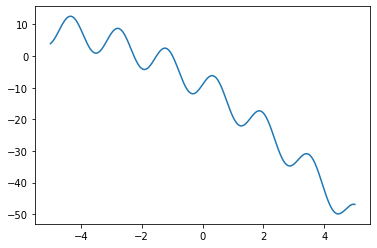

In [211]:
plt.plot(x,y)

In [365]:
ix = list(range(30)) + list(range(200,300))#random.sample(range(500),20)
xts = tl(x[ix])
yts = tl(y[ix])

In [358]:
    
for x_i in xs:
    t, p, ri = rnd(x_i)
    r.append(ri)
    int_loss = F.binary_cross_entropy(p, t.detach())
    rnd_optimizer.zero_grad()
    int_loss.backward()
    rnd_optimizer.step()

In [366]:
ls = []
for _ in range(40):
    for xt, yt in zip(xts, yts):
        yh = reg(xt.unsqueeze(0))
        loss = F.mse_loss(yh, yt)
        ls.append(loss.detach())
        reg_opt.zero_grad()
        loss.backward()
        reg_opt.step()

/home/emanuelsamir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  """


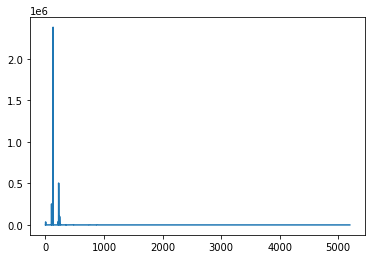

In [367]:
plt.plot(ls)

In [368]:
yh = reg(tl(x).unsqueeze(1))
yh = yh.detach().numpy().squeeze()

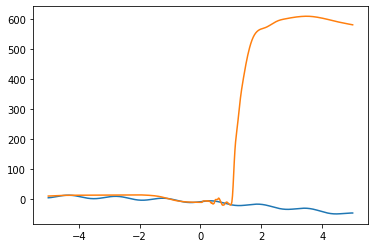

In [369]:
plt.plot(x,y)
plt.plot(x,yh)

# Plots for RND

In [4]:

def tl(x): return torch.from_numpy(x).float()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 5.)
        m.bias.data.normal_(0.0, 5.)

## Lineal

In [5]:
class RND(nn.Module):
    def __init__(self, state_dim = 16, k = 16):
        super(RND, self).__init__()      
        self.first = True

        f1 = state_dim
        f2 = 32
        f3 = 16
        f4 = 16
        self.k = k
        

        self.target =  nn.Sequential(
                            nn.Linear(f1, k),                   #nn.Sigmoid(),
                            nn.Linear(k, k),                    #nn.Sigmoid()
                            ) 

        
        self.predictor = nn.Sequential(
                            nn.Linear(f1, k),                  # nn.Sigmoid(),
                            nn.Linear(k, k),                   # nn.Sigmoid()
                            )  
        self.predictor.apply(weights_init)
        self.target.apply(weights_init)
        
            
    def fix_target(self):
        for param in self.target.parameters():
            param.requires_grad = False

    def reset(self):
        self.predictor.apply(weights_init)
        self.target.apply(weights_init)

    def forward(self, x):
        to = self.target(x)
        po = self.predictor(x)

        mse = (to - po).pow(2).sum(0) / self.k * 2

        int_reward =  mse.detach().float().unsqueeze(0)

        return to, po, int_reward
    
class RunningMeanStdWelford(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, input_size=()):
        self.mean = np.zeros(input_size, 'float32')
        self.var = np.ones(input_size, 'float32')
        self.M2 = np.ones(input_size, 'float32')
        self.count = 0

    def update(self, xt):
        x = xt.numpy()
        self.count += 1
        
        delta = x - self.mean
        self.mean += delta / self.count
        delta2 = x - self.mean
        self.M2 += delta * delta2
        res = (x - self.mean) /  (self.M2 / (self.count ) )**(0.5)
        return torch.from_numpy(res).float()


In [6]:
rnd = RND(state_dim = obs_n, k = k)
rnd.fix_target()
filt = RunningMeanStdWelford(1)
ep = 3
n = 401
path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
df = pd.read_csv(fn)
#print(df)
steps = range(1,400)
for step in steps:
    features_ns = tl(df.iloc[step,1:].values)
    t, p, ri = rnd(features_ns)
    filt.update(ri)
print(filt.mean)
print(filt.M2)

[93600.22]
[1.7654465e+10]


### Similares

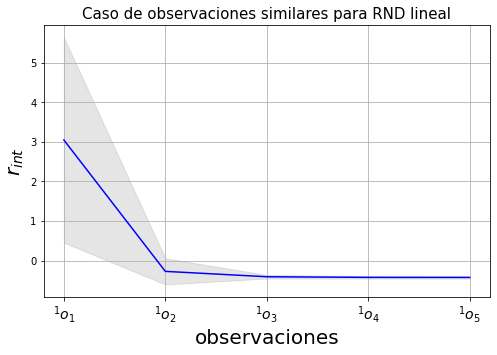

In [8]:



b = []
for _ in range(50):
    obs_n = 8
    k = 16

    SAMPLE_SIZE = 1_000
    rnd = RND(state_dim = obs_n, k = k)

    rnd.fix_target()
    rnd_optimizer = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-1)

    n_opt = 20

    ep = 3
    n = 401
    path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
    fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
    df = pd.read_csv(fn)


    steps = [1,2,3,4,5]

    
    r = []

    for step in steps:
        features_ns = tl(df.iloc[step,1:].values)

        x = features_ns.unsqueeze(0)
        xs = torch.repeat_interleave(x, n_opt, dim=0)

        for i, x_i in enumerate(xs):
            t, p, ri = rnd(x_i)
            ri =filt.update(ri)
            if i == 0:
                r.append(ri)

            int_loss = F.mse_loss(t.detach(),p)
            rnd_optimizer.zero_grad()
            int_loss.backward()
            rnd_optimizer.step()
    b.append(r)
f,ax = plt.subplots(1,1,figsize = (8,5))
b = np.array(b)
#print(b)
r = np.mean(b, axis =0)
s = np.std(b, axis = 0)



ax.plot(steps,r, 'b')

ax.fill_between(steps, r - 2*s, r + 2*s,
                 color='gray', alpha=0.2)

ax.set_title('Caso de observaciones similares para RND lineal', fontsize = 15)
leg = ['${}^1o_1$', '${}^1o_2$','${}^1o_3$', '${}^1o_4$', '${}^1o_5$']
plt.xticks(steps,leg, fontsize = 14)
ax.set_ylabel('$r_{int}$', fontsize = 20)
ax.set_xlabel('observaciones', fontsize = 20)
plt.grid(True)


### Diferentes

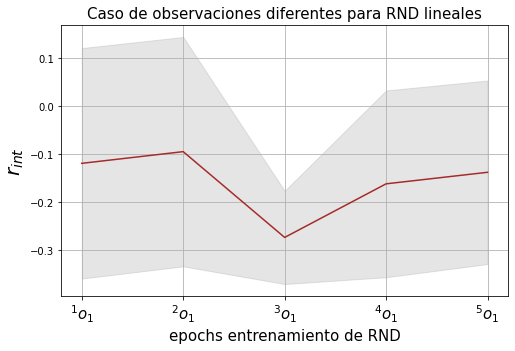

In [9]:
b = []
for _ in range(50):
    rnd = RND(state_dim = 8)
    rnd.fix_target()

    rnd_optimizer = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-1 )
    n_opt = 30

    ep = 3
    path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
    #path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'

    ns = [401,401,401,401,401,401]#,401,401,401]# 67,8,89,110,30,116,201,194]
    eps = [30,31,36,33,34,35]#,36,37]


    r = []

    for ep, n in zip(eps, ns):
        fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
        df = pd.read_csv(fn)
        features_ns = tl(df.iloc[-1,1:].values)

        x = features_ns.unsqueeze(0)
        xs = torch.repeat_interleave(x, n_opt, dim=0)



        for i, x_i in enumerate(xs):
            t, p, ri = rnd(x_i)
            ri =filt.update(ri)
            if i == 0:
                r.append(ri)
            

            #r.append(ri)
            int_loss = F.mse_loss(p, t.detach())
            #int_loss = F.binary_cross_entropy(p, t.detach())

            rnd_optimizer.zero_grad()
            int_loss.backward()
            rnd_optimizer.step()
    b.append(r)

b = np.array(b)
#print(b)
r = np.mean(b, axis =0)
s = np.std(b, axis = 0)

r = r[1:]
s = s[1:]

        
f,ax = plt.subplots(1,1,figsize = (8,5))

steps = [1,2,3,4,5]
ax.plot(steps,r, 'brown')
ax.fill_between(steps, r - 2*s, r + 2*s,
                 color='gray', alpha=0.2)
    
ax.set_title('Caso de observaciones diferentes para RND lineales', fontsize = 15)    
leg = ['${}^1o_1$', '${}^2o_1$','${}^3o_1$', '${}^4o_1$', '${}^5o_1$']
plt.xticks(steps,leg, fontsize = 15)
ax.set_ylabel('$r_{int}$', fontsize = 20)
ax.set_xlabel('epochs entrenamiento de RND', fontsize = 15)
plt.grid(True)


## Sigmoide

In [11]:
class RND(nn.Module):
    def __init__(self, state_dim = 16, k = 16):
        super(RND, self).__init__()      
        self.first = True

        f1 = state_dim
        f2 = 32
        f3 = 16
        f4 = 16
        self.k = k
        

        self.target =  nn.Sequential(
                            nn.Linear(f1, k),                   nn.Sigmoid(),
                            nn.Linear(k, k),                    nn.Sigmoid()
                            ) 

        
        self.predictor = nn.Sequential(
                            nn.Linear(f1, k),                   nn.Sigmoid(),
                            nn.Linear(k, k),                   nn.Sigmoid()
                            )  
        self.predictor.apply(weights_init)
        self.target.apply(weights_init)
        
            
    def fix_target(self):
        for param in self.target.parameters():
            param.requires_grad = False

    def reset(self):
        self.predictor.apply(weights_init)
        self.target.apply(weights_init)

    def forward(self, x):
        to = self.target(x)
        po = self.predictor(x)

        mse = (to - po).pow(2).sum(0) / self.k * 2

        int_reward =  mse.detach().float().unsqueeze(0)

        return to, po, int_reward

### Similares

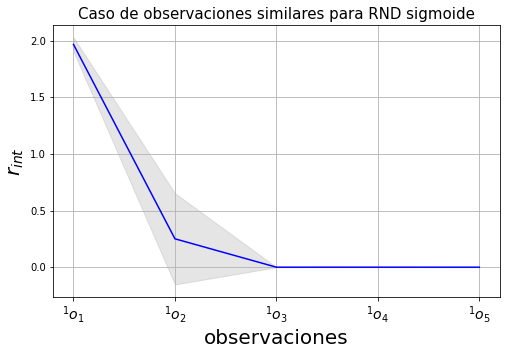

In [12]:

b = []
for _ in range(10):
    obs_n = 8
    k = 16

    SAMPLE_SIZE = 1_000
    rnd = RND(state_dim = obs_n, k = k)
    
    predictor_opt = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-2)
    target_opt = torch.optim.Adam(rnd.target.parameters(), lr = 1e-2)

    pred_data_in = torch.rand((SAMPLE_SIZE, obs_n))
    target_data_in = torch.rand((SAMPLE_SIZE, obs_n))

    pred_data_out = torch.zeros((SAMPLE_SIZE, k), requires_grad=False)
    target_data_out = torch.ones((SAMPLE_SIZE, k), requires_grad=False)

    for i in range(SAMPLE_SIZE):
        pred_loss = F.binary_cross_entropy(rnd.predictor(pred_data_in[i]), pred_data_out[i])
        predictor_opt.zero_grad()
        pred_loss.backward()
        predictor_opt.step()

        target_loss = F.binary_cross_entropy(rnd.target(target_data_in[i]), target_data_out[i])
        target_opt.zero_grad()
        target_loss.backward()
        target_opt.step()

    rnd.fix_target()
    rnd_optimizer = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-1)

    n_opt = 20

    ep = 3
    n = 401
    path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
    fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
    df = pd.read_csv(fn)


    steps = [1,2,3,4,5]

    
    r = []

    for step in steps:
        features_ns = tl(df.iloc[step,1:].values)

        x = features_ns.unsqueeze(0)
        xs = torch.repeat_interleave(x, n_opt, dim=0)

        for i, x_i in enumerate(xs):
            t, p, ri = rnd(x_i)
            if i == 0:
                r.append(ri)

            int_loss = F.binary_cross_entropy(p, t.detach())
            rnd_optimizer.zero_grad()
            int_loss.backward()
            rnd_optimizer.step()
    b.append(r)
    
f,ax = plt.subplots(1,1,figsize = (8,5))
b = np.array(b)
#print(b)
r = np.mean(b, axis =0)
s = np.std(b, axis = 0)

ax.plot(steps,r, 'b')

ax.fill_between(steps, r - 2*s, r + 2*s,
                 color='gray', alpha=0.2)

ax.set_title('Caso de observaciones similares para RND sigmoide', fontsize = 15)
leg = ['${}^1o_1$', '${}^1o_2$','${}^1o_3$', '${}^1o_4$', '${}^1o_5$']
plt.xticks(steps,leg, fontsize = 14)
ax.set_ylabel('$r_{int}$', fontsize = 20)
ax.set_xlabel('observaciones', fontsize = 20)
plt.grid(True)


### Diferentes

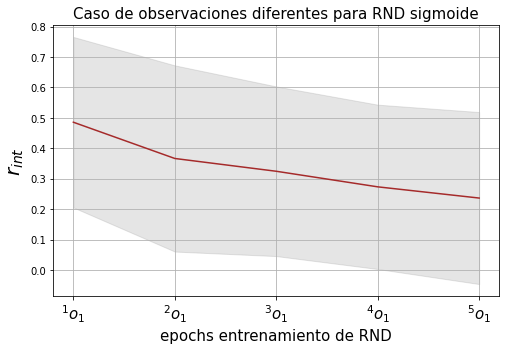

In [13]:
b = []
for _ in range(10):
    rnd = RND(state_dim = 8)
    
    predictor_opt = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-2)
    target_opt = torch.optim.Adam(rnd.target.parameters(), lr = 1e-2)

    pred_data_in = torch.rand((SAMPLE_SIZE, obs_n))
    target_data_in = torch.rand((SAMPLE_SIZE, obs_n))

    pred_data_out = torch.zeros((SAMPLE_SIZE, k), requires_grad=False)
    target_data_out = torch.ones((SAMPLE_SIZE, k), requires_grad=False)

    for i in range(SAMPLE_SIZE):
        pred_loss = F.binary_cross_entropy(rnd.predictor(pred_data_in[i]), pred_data_out[i])
        predictor_opt.zero_grad()
        pred_loss.backward()
        predictor_opt.step()

        target_loss = F.binary_cross_entropy(rnd.target(target_data_in[i]), target_data_out[i])
        target_opt.zero_grad()
        target_loss.backward()
        target_opt.step()

    rnd.fix_target()
    rnd_optimizer = torch.optim.Adam(rnd.predictor.parameters(), lr = 1e-1 )
    n_opt = 30

    ep = 3
    path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'
    #path = '../specials/A2CiLSTMRNDPN/_0526_22-30-30/'

    ns = [401,401,401,401,401, 401]#,401,401,401]# 67,8,89,110,30,116,201,194]
    eps = [30,31,32,33,34,35]#,36,37]


    r = []

    for ep, n in zip(eps, ns):
        fn = join(path, 'e{}_n{}'.format(ep, n), 'data.csv')
        df = pd.read_csv(fn)
        features_ns = tl(df.iloc[-1,1:].values)

        x = features_ns.unsqueeze(0)
        xs = torch.repeat_interleave(x, n_opt, dim=0)



        for i, x_i in enumerate(xs):
            t, p, ri = rnd(x_i)
            if i == 0:
                r.append(ri)

            #r.append(ri)
            int_loss = F.mse_loss(p, t.detach())
            #int_loss = F.binary_cross_entropy(p, t.detach())

            rnd_optimizer.zero_grad()
            int_loss.backward()
            rnd_optimizer.step()
    b.append(r)

b = np.array(b)
#print(b)
r = np.mean(b, axis =0)
s = np.std(b, axis = 0)
        
f,ax = plt.subplots(1,1,figsize = (8,5))

r = r[1:]
s = s[1:]


steps = [1,2,3,4,5]
ax.plot(steps,r, 'brown')
ax.fill_between(steps, r - 2*s, r + 2*s,
                 color='gray', alpha=0.2)
    
ax.set_title('Caso de observaciones diferentes para RND sigmoide', fontsize = 15)    
leg = ['${}^1o_1$', '${}^2o_1$','${}^3o_1$', '${}^4o_1$', '${}^5o_1$']
plt.xticks(steps,leg, fontsize = 15)
ax.set_ylabel('$r_{int}$', fontsize = 20)
ax.set_xlabel('epochs entrenamiento de RND', fontsize = 15)
plt.grid(True)
